In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
import cv2 as cv
from keras.layers import Input
%matplotlib inline
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import Flatten,Dense
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
import keras

In [2]:
path=r"C:\Users\User\Desktop\lfw"
image_path=[i for i in os.listdir(path)]

images=[]
for i in image_path:
    folders=os.path.join(path,i)
    for j in os.listdir(folders):
        image_path1=j
        image=cv.imread(os.path.join(folders,image_path1))
        image=cv.cvtColor(image, cv.COLOR_BGR2RGB)
        images.append(image)

In [3]:
resized_images=np.zeros((len(images),45,45,3),dtype=np.uint8)

In [4]:
for i in range(len(resized_images)):
    resized_images[i]=cv.resize(images[i],(45,45))

In [5]:
resized_images.shape

(13233, 45, 45, 3)

In [6]:
X_train = resized_images[:10000]
print(X_train.shape)
X_val = resized_images[10000:]
print(X_val.shape)

image_h = resized_images.shape[1]
image_w = resized_images.shape[2]

(10000, 45, 45, 3)
(3233, 45, 45, 3)


In [7]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [8]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

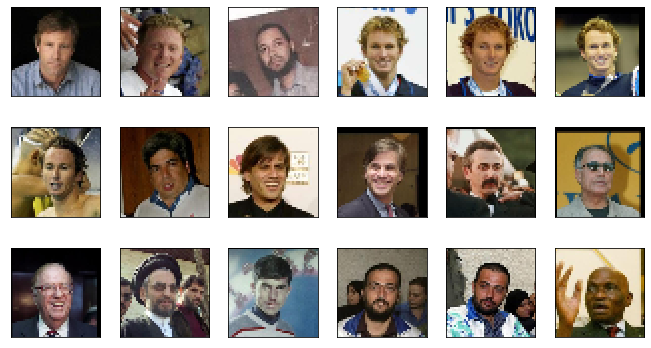

In [9]:
plot_gallery(X_train, image_h, image_w)

In [10]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [11]:
dimz = 100

input_img = Input(shape=(45,45,3))
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) 
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [17]:
z_mean =Dense(dimz)(x)
z_log_var =Dense(dimz)(x)

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], dimz))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [24]:
z = keras.layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(input_img, [z_mean, z_log_var, z])
encoder.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45, 45, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 45, 45, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 23, 23, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 23, 23, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [25]:
class CropToBoundingBox(keras.layers.Layer):
    def call(self, inputs):
        return tf.image.crop_to_bounding_box(inputs, 1, 1, 45, 45)

latent_inputs = keras.Input(shape=(dimz,))
x = Dense(12 * 12 * 64, activation="relu")(latent_inputs)
x = keras.layers.Reshape((12, 12, 64))(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(3, 4, activation="sigmoid", padding="same")(x)
x = CropToBoundingBox()(x) 

decoder_outputs = x

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 9216)              930816    
                                                                 
 reshape_1 (Reshape)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 24, 24, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 48, 48, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 48, 48, 3)        771 

In [26]:
import tensorflow as tf
from tensorflow import keras


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

     
    def KL_divergence(self, mu, logsigma):
        kl_div = -0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma), axis=-1)
        return tf.reduce_mean(kl_div)


    def log_likelihood(self, x, z):
        log_likelihood = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, z), axis=(1, 2))
        return tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss=self.log_likelihood(data,reconstruction) 
            kl_loss=self.KL_divergence(z_mean,z_log_var)
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed_output = self.decoder(z)
        return reconstructed_output


In [27]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)

In [28]:
history = vae.fit(X_train, X_train,
    epochs=10,
    validation_data = (X_val, X_val),
    callbacks=[callback]
)

Epoch 1/10
  5/313 [..............................] - ETA: 1:11 - loss: 1400.9487 - reconstruction_loss: 1400.7725 - kl_loss: 0.1763

KeyboardInterrupt: 

1/1 [==============================] - 0s 49ms/step


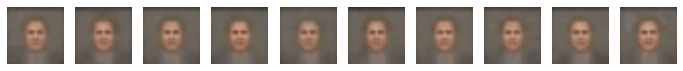

In [65]:
latent_vectors = np.random.standard_normal(size=(10, dimz))  
generated_images = vae.decoder.predict(latent_vectors)

generated_images = generated_images * 255
generated_images = generated_images.astype(np.uint8)

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.show()

In [77]:
from sklearn.datasets import fetch_lfw_people

In [78]:
(xtrain,ytrain),(xtest,ytest)=fetch_lfw_people()

KeyboardInterrupt: 

In [124]:
X = lfw_dataset.data  # Image data
y = lfw_dataset.target

In [125]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [126]:
X = lfw_dataset.data 

In [127]:
X.shape

(1288, 1850)

In [132]:
X.shape

(1288, 1850)

In [88]:
a

array([[[8.33395557e-01, 7.26468693e-01, 2.08513325e-01],
        [2.98001927e-01, 8.55687264e-01, 6.03176998e-01],
        [3.40469653e-01, 6.29070099e-01, 9.41699510e-01],
        [1.26532416e-01, 6.48937613e-01, 2.50187089e-01],
        [6.19351851e-01, 4.56219500e-01, 9.58286100e-01],
        [7.24384023e-01, 4.54018666e-01, 4.04945491e-01],
        [7.66037449e-01, 6.94566522e-02, 8.04280868e-01],
        [3.14614843e-01, 8.09940901e-01, 6.95687888e-01],
        [1.25777978e-01, 5.87317177e-01, 1.39383283e-01],
        [9.69989746e-01, 6.80228494e-02, 8.73122301e-01]],

       [[1.22313258e-01, 8.70809354e-01, 8.30768350e-02],
        [5.00807991e-01, 9.54290147e-01, 6.56370461e-01],
        [8.31265229e-01, 2.20274352e-01, 1.11244707e-01],
        [9.43696832e-01, 1.09417924e-02, 3.90841276e-01],
        [5.19796224e-01, 2.54360798e-01, 7.43353282e-01],
        [1.92671488e-01, 7.50995266e-01, 1.04230528e-01],
        [3.03080400e-01, 7.13794479e-01, 4.84823114e-01],
        [2.0

In [89]:
from sklearn.datasets import fetch_lfw_people

In [90]:
data=fetch_lfw_people()

In [100]:
imag=data["data"]

In [101]:
res_images=np.zeros((len(imag),45,45),dtype=np.uint8)

In [102]:
for i in range(len(resized_images)):
    res_images[i]=cv.resize(imag[i],(45,45))

NameError: name 'resize_images' is not defined

In [116]:
imag=np.resize(imag,(13233,45,45))

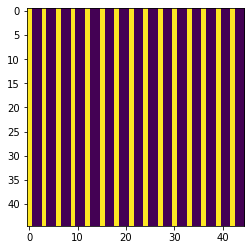

In [122]:
plt.imshow(imag[25])

In [114]:
image.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [123]:
plt.imshow(ima)

(13233, 45, 45)